In [8]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

In [9]:
digits = load_digits(n_class=6)
X, y = digits.data, digits.target
n_samples, n_features = X.shape
print(X[0])
print(n_samples, n_features)

[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]
1083 64


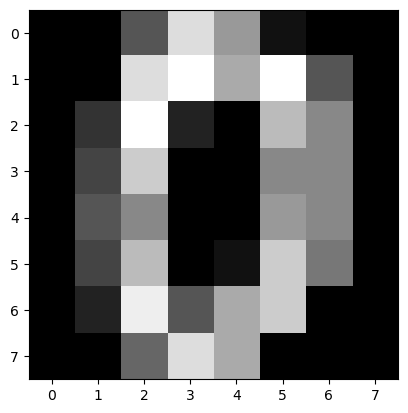

In [10]:
# reshape X[0] to a 2D array
img = np.reshape(X[0], (8, 8))

# plot the image
plt.imshow(img, cmap='gray')
plt.show()


# FARE TRAIN TEST SPLIT DOPO!!!!

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=124)

# basic_classifier = svm.SVC(gamma=0.001)
basic_classifier = KNeighborsClassifier(n_neighbors=3)
basic_classifier.fit(x_train, y_train)
predicted = basic_classifier.predict(x_test)

# print("Classification report for classifier %s:\n%s\n")
# print(classification_report(y_test, predicted))

print("Accuracy score: ", accuracy_score(y_test, predicted))

Accuracy score:  0.996309963099631


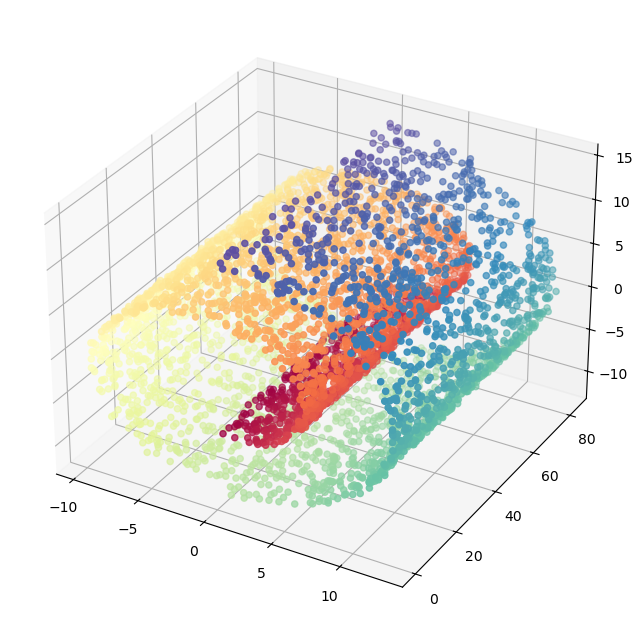

In [12]:
def make_swiss_roll(n_samples=100, noise=0.0, random_state=None):
    #Generate a swiss roll dataset.
    t = 1.5 * np.pi * (1 + 2 * np.random.rand(1, n_samples))
    x = t * np.cos(t)
    y = 83 * np.random.rand(1, n_samples)
    z = t * np.sin(t)
    X = np.concatenate((x, y, z))
    X += noise * np.random.randn(3, n_samples)
    X = X.T
    t = np.squeeze(t)
    return X, t

X_swiss, Y_swiss = make_swiss_roll(n_samples = 5000, noise=0.1, random_state=42)

plt.figure(figsize=(8, 8))
ax = plt.subplot(projection='3d')
ax.scatter(X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2], c=Y_swiss, cmap=plt.cm.Spectral)
plt.show()

# Neighborhood Preserving Embedding (NPE)
![alt text](img/NPE_algorithm.png "Algorithm")


## Step 1: KNN from scratch

In [13]:
X = x_train
y = y_train
# X = X_swiss
# y = Y_swiss

In [14]:
from sklearn.neighbors import NearestNeighbors

# Create a NearestNeighbors model
k = 4  # You can change this value to the number of neighbors you want
nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto', n_jobs=-1).fit(X)
k = k - 1 #This becase the first neighbor is the point itself

# Query for nearest neighbors
Q_distances = []
Q_indices = []
for i in range(len(X)):
    distance, index = nbrs.kneighbors([X[i]])
    # print("distance: ", distance[0])
    # print("index: ", index[0])
    Q_distances.append(distance[0][1:])
    Q_indices.append(index[0][1:])

# distances: Array of distances to the k nearest neighbors
# indices: Array of indices of the k nearest neighbors in x_train

# print(Q_distances)
# print(Q_indices[0])


## Step 2: Compute the weight matrix W


To construct the weight matrix $W \in \mathbb{R}^{m \times m}$, where the $(i+1)$-th row and $(j+1)$-th column element is $W_{ij}$, the objective function to optimize is:


$$\min \sum_{i}\Vert {\bf x}_{i}-\sum_{j}W_{ij}{\bf x}_{j}\Vert^{2}$$
with contraints $\sum_{j}W_{ij}=1,j=1,2, \ldots, m$

Let $C^{(i)}$ denote an $m x m$ matrix relatex to $x_i$, called neighborhood correlation matrix, where:

![alt text](img/formula_3.png)

Then, let $W_i$ denotes the $(i + 1)$-th row of matrix $W$, then the solution of the objective function is:

![alt text](img/formula_4.png)

In [15]:
tol = 1e-5



n = len(X)
# W = np.zeros((n, n))
W = []
k_1 = np.ones((k))
I = np.ones((k, 1))

for i in range(n):
    xi = X[i]
    C = []
    for j in range(k):
        xj = X[Q_indices[i][j]]
        C_aux = []
        for m in range(k):
            xm = X[Q_indices[i][m]]
            C_jk =(xi - xj).T @ (xi - xm)
            C_aux.append(C_jk)
        C.append(C_aux)
    C = np.array(C)
    # print(C.shape)
    C = C + tol * np.eye(*C.shape) # Regularization for C
    w = np.linalg.inv(C) @ k_1
    w = w / (k_1.T @ np.linalg.inv(C) @ k_1)

    # Create an 1 x n array that will contain a 0 if xj is not a 
    # neighbour of xi, otherwise it will cointain the weight of x_j
    w_real = np.zeros((1, n))
    np.put(w_real, Q_indices[i], w)
    W.append(list(w_real[0]))

W = np.array(W)
print(W.shape)

(812, 812)


## Step 3: Computing the projections
In this step, we compute the linear projections. Solve the following generalized eigenvector problem:
$$XMX^{T}{\bf a}=\lambda XX^{T}{\bf a}$$
Where
$$\ \ X=({\bf x}_{1}, \cdots, {\bf x}_{m}) \\ M=(I-W)^{T}(I-W) \\ I=diag(1, \cdots, 1)$$
There are many different method to solve the eigenvalue problem. In this implementation, we use the method of the spectral regression (SR). \
The eigenvalue problem can be solved by two steps. \
First step: solve the following eigenvalue problem to get the bottom non-zero eigenvectors $z_{0}, z_{1}, \cdots, z_{d-1}$:
$$Mz = \lambda z$$
Second step: Find $a_i$ that satisfies 

![alt text](img/formula_8.png)

where $z_{ij}$ is the $j$-th element of $z_i$ and $\alpha >= 0$ is a regularization parameter. 


In [16]:
# X = X_swiss

d = 2
alpha = 1e-5


def compute_projection_matrix(X, d, alpha):

    A = []
    I = np.eye(n)

    M = (I - W).T @ (I - W)


    # eigvalues, eigvectors = linalg.eigs(M, k=d, which='LM')
    eigvalues, eigvectors = np.linalg.eig(M)

    # z = eigvectors

            # sort eigenvectors
    # pairs = list(zip(eigvalues, eigvectors.T)) # Pair each eigenvalue with its corresponding eigenvector
    # pairs.sort(key=lambda x: x[0], reverse=False) # Sort the pairs in ascending order of the eigenvalue
    # sorted_eigvalues, sorted_eigvectors = zip(*pairs) # Unpack the sorted pairs
    # z = np.array(sorted_eigvectors).T # Convert the sorted eigenvectors back to a 2D array

    # Sort the eigenvalues and eigenvectors in ascending order
    index_ = np.argsort(np.abs(eigvalues))[1:d+1]
    z = eigvectors[:, index_]

    I = np.eye(X.shape[1])
    for i in range(d):
        ai = (X.T @ X) + (alpha * I)
        ai = np.linalg.inv(ai)
        ai = ai @ X.T @ z[:, i]
        A.append(ai)


    A = np.array(A).T
    return A

A = compute_projection_matrix(X, d, alpha)

### Transforming the data

In [17]:
A.shape


(64, 2)

In [18]:
def trasforming_data(X, A):

    x_train_transformed = []
    x_test_transformed = []
    for i in range(X.shape[0]):
        x_train_transformed.append( A.T @ X[i])
    # for i in range(len(x_test)):
    #     x_test_transformed.append( A.T @ x_test[i])
    # print(x_train_transformed)
    x_train_transformed = np.array(x_train_transformed)
    x_test_transformed = np.array(x_test_transformed)

    return x_train_transformed, x_test_transformed

x_train_transformed, x_test_transformed = trasforming_data(X, A)

## Evaluation
pca
mds
isomap
lle
kernel pca
diffusion maps
sketch map
t-sne
umap
(autoencoders)

In [19]:
from myAlg.myPCA import myPCA, myKernelPCA
from myAlg.myISOMAP import isomap
from myAlg.myMDS import myMDS
from sklearn.manifold import TSNE, LocallyLinearEmbedding, MDS
import umap

from sklearn.metrics import silhouette_score
import time

dim = 2

pca = myPCA()
kernel_pca = myKernelPCA(kernel='poly', sigma=1.3)
mds = MDS(n_components=dim, normalized_stress='auto')
lle = LocallyLinearEmbedding(n_components=dim, n_jobs=-1, n_neighbors=12)
tsne = TSNE(n_components=dim, method='exact', n_jobs=-1)

A = compute_projection_matrix(X, d, alpha)
x_train_transformed, _ = trasforming_data(X, A)
x_train_transformed_pca = pca.fit_transform(X, dim)
x_train_transformed_kernel_pca = kernel_pca.fit_transform(X, dim)
x_train_transformed_mds = mds.fit_transform(X)
x_train_transformed_isomap = isomap(X, n_neighbors=5, n_components=dim)
x_train_transformed_lle = lle.fit_transform(X)
x_train_transformed_tsne = tsne.fit_transform(X)


list_of_transformations = [x_train_transformed, x_train_transformed_pca, x_train_transformed_kernel_pca, x_train_transformed_mds, x_train_transformed_isomap, x_train_transformed_lle, x_train_transformed_tsne]
list_of_names = ["NPE", "PCA", "Kernel PCA", "MDS", "Isomap", "LLE", "t-SNE"]
print("Number of dimension: ", dim)
acc = []
sil = []
i=0
# for x_trans in list_of_transformations:
#     basic_classifier = KNeighborsClassifier(n_neighbors=3)
#     basic_classifier.fit(x_trans, y_train)
#     start = time.time()
#     predicted = basic_classifier.predict(x_trans)
#     end = time.time()
#     # print("Time for", list_of_names[i], ": ", round(end - start, 4))
#     print("Accuracy for", list_of_names[i], ": ", round(accuracy_score(y_train, predicted), 3))
#     print("silhouette_score for ", list_of_names[i], ": ", silhouette_score(x_trans, y_train))
#     acc.append(accuracy_score(y_train, predicted))
#     sil.append(silhouette_score(x_trans, y_train))
#     i+=1

ValueError: shapes (812,64) and (812,812) not aligned: 64 (dim 1) != 812 (dim 0)

Time for NPE :  0.021\
Time for PCA :  0.018\
Time for Kernel PCA :  0.018\
Time for MDS :  0.02\
Time for Isomap :  0.014\
Time for LLE :  0.016\
Time for t-SNE :  0.014\
<!-- Time for Spectral Embedding :  0.014\ -->

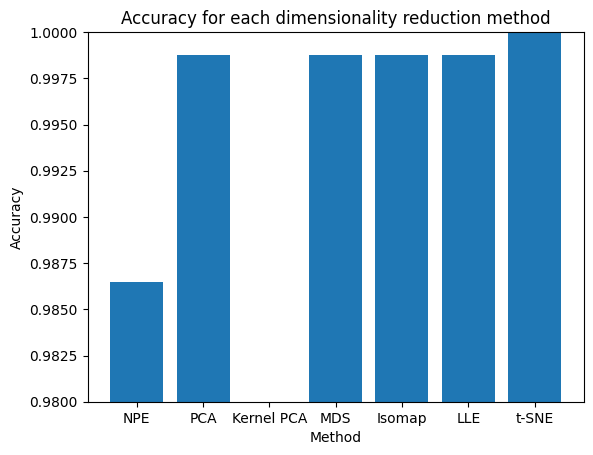

In [ ]:
plt.bar(list_of_names, acc)
plt.title("Accuracy for each dimensionality reduction method")
plt.xlabel("Method")
plt.ylabel("Accuracy")
plt.ylim(0.98, 1.00)
plt.show()


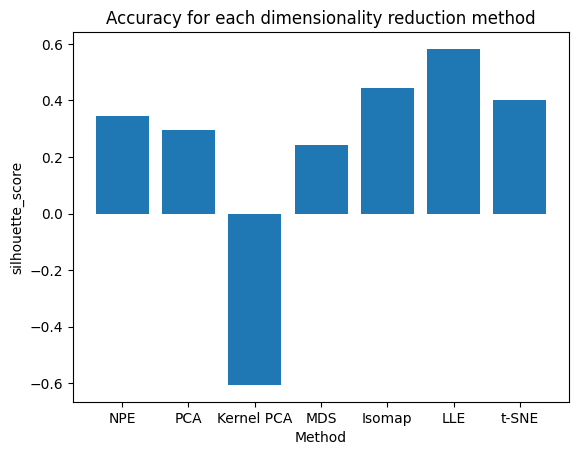

In [ ]:
plt.bar(list_of_names, sil)
plt.title("Silhouette score for each dimensionality reduction method")
plt.xlabel("Method")
plt.ylabel("silhouette_score")
plt.show()

In [ ]:
basic_classifier = KNeighborsClassifier(n_neighbors=3)

list_of_transformations = [x_train_transformed, x_train_transformed_pca, x_train_transformed_kernel_pca, x_train_transformed_mds, x_train_transformed_isomap, x_train_transformed_lle, x_train_transformed_tsne, x_train_transformed_spectral_embedding]
list_of_names = ["NPE", "PCA", "Kernel PCA poly", "MDS", "Isomap", "LLE", "t-SNE", "Spectral Embedding"]

i=0
for x_trans in list_of_transformations:
    basic_classifier = KNeighborsClassifier(n_neighbors=3)
    basic_classifier.fit(x_trans, y_train)
    predicted = basic_classifier.predict(x_trans)
    print("Accuracy score for", list_of_names[i], ": ", round(accuracy_score(y_train, predicted), 3))
    i+=1

Accuracy score for NPE :  0.986
Accuracy score for PCA :  0.89
Accuracy score for Kernel PCA :  0.59
Accuracy score for MDS :  0.93
Accuracy score for Isomap :  0.993
Accuracy score for LLE :  0.984
Accuracy score for t-SNE :  1.0
Accuracy score for Spectral Embedding :  0.956


In [ ]:
# TEST WITH Y_TEST, IF IT DOES A GOOD WORK IN GENERALIZING THE DATA


# basic_classifier = svm.SVC(gamma=0.001)
basic_classifier = KNeighborsClassifier(n_neighbors=3)
basic_classifier.fit(x_train_transformed, y_train)
predicted = basic_classifier.predict(x_test_transformed)

# print("Classification report for classifier %s:\n%s\n")
# print(classification_report(y_test, predicted))

print("Accuracy score: ", accuracy_score(y_test, predicted))

Accuracy score:  0.9852216748768473


## Step 4: Visualizing the results

/home/thomas/anaconda3/envs/unsup/lib/python3.10/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


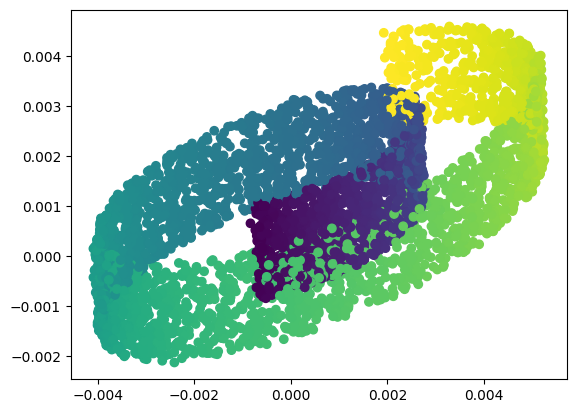

In [ ]:


plt.scatter(x_train_transformed[:, 0], x_train_transformed[:, 1], c=y)
plt.show()


In [ ]:
list_of_transformations[5] = X_lle

/home/thomas/anaconda3/envs/unsup/lib/python3.10/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


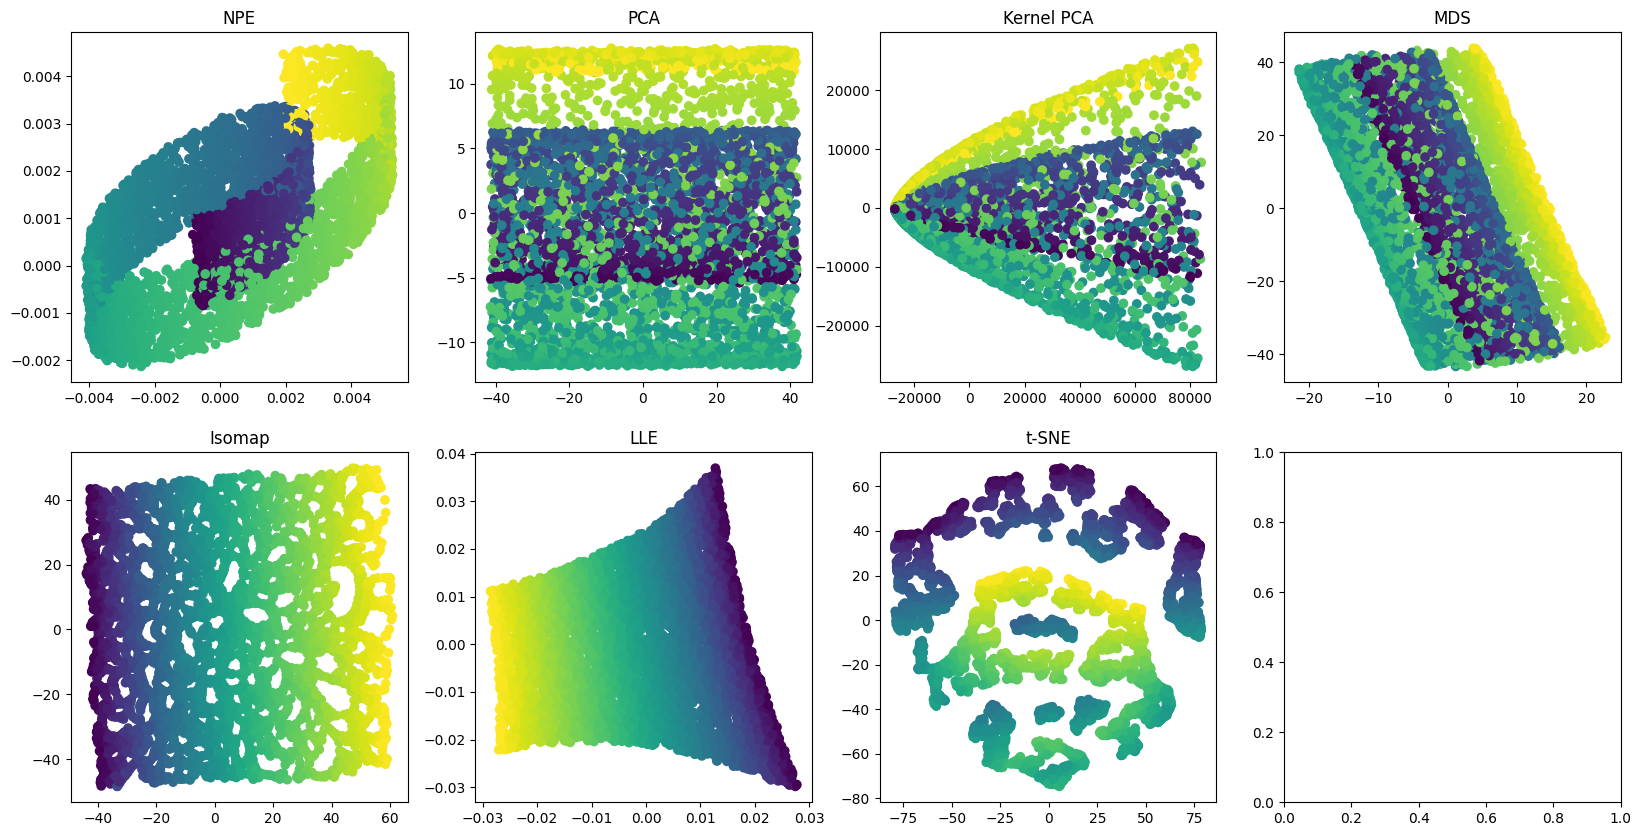

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.ravel()

for i, (transformation, name) in enumerate(zip(list_of_transformations, list_of_names)):
    axs[i].scatter(transformation[:, 0], transformation[:, 1], c=y)
    axs[i].set_title(name)

plt.show()


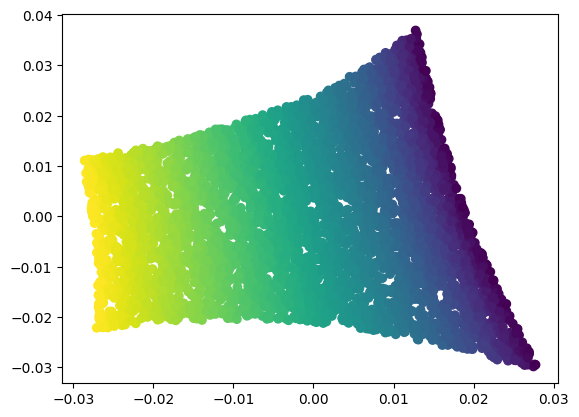

In [ ]:
from sklearn.manifold import locally_linear_embedding
from sklearn.manifold import LocallyLinearEmbedding

# X_lle, err = locally_linear_embedding(X_swiss, n_neighbors=12, n_components=2)
lle = LocallyLinearEmbedding(n_neighbors=12, n_components=2, n_jobs=-1)
X_lle = lle.fit_transform(X_swiss)
plt.scatter(X_lle[:, 0], X_lle[:, 1], c=Y_swiss)
plt.show()


In [ ]:

mds = MDS(n_components=2, n_jobs=-1)
X_mds = mds.fit_transform(X_swiss)
plt.scatter(X_mds[:, 0], X_mds[:, 1], c=Y_swiss)
plt.show()

/home/thomas/anaconda3/envs/unsup/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


KeyboardInterrupt: 

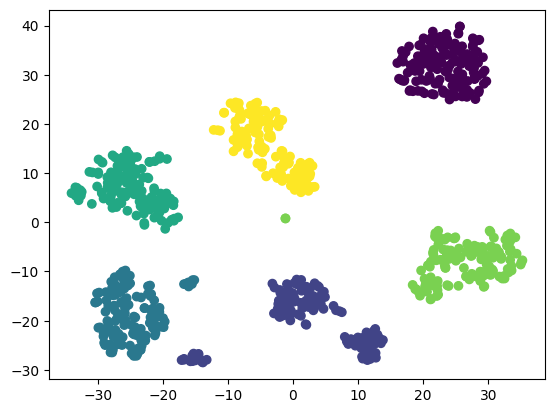

In [ ]:
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2).fit_transform(X)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y)
plt.show()

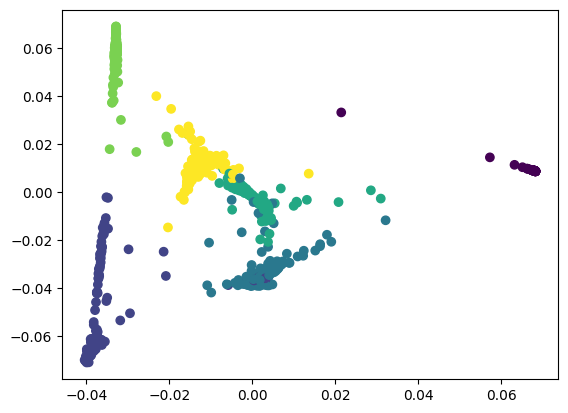

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=d, n_neighbors=k)
lle_data = lle.fit_transform(X)


plt.scatter(lle_data[:, 0], lle_data[:, 1], c=y_train)
plt.show()


[5.336924479002934e-17, 1.2577368922855241e-08, 2.8852503251537177e-06, 3.9168319134666046e-06, 1.483166139871425e-05, 2.6432973199950186e-05, 8.098138580644574e-05, 0.0002478928927177285, 0.00038261347308358193, 0.0004636267083731307, 0.0005617122346365519, 0.0006490289258128288, 0.0009553059814434845, 0.001063691687749234, 0.0013098664951440736, 0.0016963920540143068, 0.0017624832378264578, 0.0019080285560364352, 0.002277233357697585, 0.0025804029512232415, 0.002812022382727536, 0.003398654669997946, 0.0034763786496748122, 0.003942231062957168, 0.004101063080231693, 0.004256501504693037, 0.0043512556468272194, 0.004731899026932088, 0.0050474182385816194, 0.005735292880744451, 0.006178742063787087, 0.006274510418178372, 0.006775934504891943, 0.007487583793533895, 0.007521199295489862, 0.007962123476615604, 0.008729034036841237, 0.009087274902989358, 0.009314355276670525, 0.009645556731781791, 0.0107673380192001, 0.011107194898040828, 0.011140951197098197, 0.011631163186363433, 0.01191

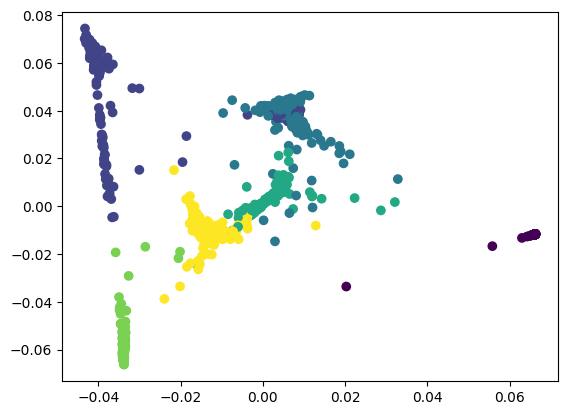

In [ ]:
# ## THIS IS A TEST

## LLE algorithm

d = 2

I = np.eye(n)
M = (I - W).T @ (I - W)

eigvalues, eigvectors = np.linalg.eig(M)
print(sorted(np.abs(eigvalues)))
index_ = np.argsort(np.abs(eigvalues))[1:d+1]
lle_data = eigvectors[:, index_]

plt.scatter(lle_data[:, 0], lle_data[:, 1], c=y_train)
plt.show()